In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import os
from PIL import Image
from tensorflow.keras.models import Model

# After downloading Air-Pollution-Image-Dataset-From-India-and-Nepal dataset from kaggle, extract it and pass the path for all the respective csv file for training, validation and test.

In [2]:
# Specify the file paths for the training, validation, and testing CSV files
train_csv_file = 'Datasets/train_data.csv'
val_csv_file = 'Datasets/val_data.csv'
test_csv_file = 'Datasets/testing_data.csv'

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Read the training CSV file into a DataFrame
train_df = pd.read_csv(train_csv_file)

print(train_df['AQI_Class'].value_counts(normalize=True))
classes = np.unique(train_df['AQI_Class'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['AQI_Class'])
class_weight_dict = dict(zip(classes, class_weights))

# Read the validation CSV file into a DataFrame
val_df = pd.read_csv(val_csv_file)

# Read the testing CSV file into a DataFrame
test_df = pd.read_csv(test_csv_file)

def compute_dataset_stats(data_dir, target_size=(224, 224)):
    images = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).resize(target_size)
                img = np.array(img) / 255.0  # 將像素值縮放到 [0, 1]
                images.append(img)

    images = np.array(images)
    mean = np.mean(images, axis=(0, 1, 2))  # 對每個通道計算均值
    std = np.std(images, axis=(0, 1, 2))    # 對每個通道計算標準差
    return mean, std

path = 'Datasets/Images'
mean, std = compute_dataset_stats(path)

def custom_standardization(image, mean=mean, std=std):
    return (image - mean) / std

# Create ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

AQI_Class
c_Unhealthy_for_Sensitive_Groups    0.233882
d_Unhealthy                         0.214222
e_Very_Unhealthy                    0.179242
b_Moderate                          0.128431
a_Good                              0.125878
f_Severe                            0.118345
Name: proportion, dtype: float64
Found 7833 validated image filenames belonging to 6 classes.
Found 1959 validated image filenames belonging to 6 classes.
Found 2448 validated image filenames belonging to 6 classes.


# write your code here to create and train your model for image classificatoin for AQI class

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 手刻模型的頂層（例如自定義分類層）
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 凍結預訓練層（可選）
for layer in base_model.layers:
    layer.trainable = False

In [12]:
#compile your model here
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#train you model here

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 5 個 epoch 無改善則停止訓練
    mode='min',  # 監控 val_loss 的最小值
    restore_best_weights=True,  # 恢復最佳權重
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # 學習率乘以 0.5
    patience=3,  # 3 個 epoch 無改善則降低學習率
    min_lr=1e-5,  # 最小學習率
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=200,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

model.save('resnet50_pretrained_aqi_model.h5')

Epoch 1/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 81s 228ms/step - accuracy: 0.3067 - loss: 32.1298 - val_accuracy: 0.2338 - val_loss: 28.2420 - learning_rate: 1.0000e-04
Epoch 2/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.4796 - loss: 26.3858 - val_accuracy: 0.3012 - val_loss: 23.4004 - learning_rate: 1.0000e-04
Epoch 3/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - accuracy: 0.5322 - loss: 21.7653 - val_accuracy: 0.5758 - val_loss: 18.9687 - learning_rate: 1.0000e-04
Epoch 4/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.5977 - loss: 18.0916 - val_accuracy: 0.2318 - val_loss: 19.5341 - learning_rate: 1.0000e-04
Epoch 5/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - accuracy: 0.6281 - loss: 15.2619 - val_accuracy: 0.4058 - val_loss: 14.2955 - learning_rate: 1.0000e-04
Epoch 6/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.6476 - loss: 13.0856 - val_accuracy: 0.4308 - val_loss: 12.4820 - learning_rate: 1.0000e-04
Epoch 7/200
245/245 ━━━━━━━━

# plot your Training Accuracy and validation accuracy here

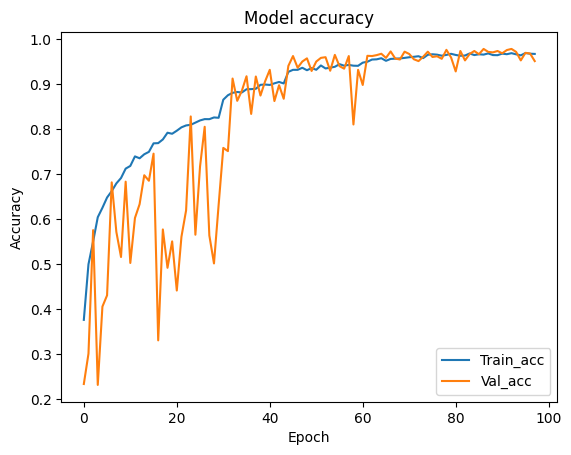

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.legend(['Train_acc', 'Val_acc'], loc='lower right')
plt.show()

# Test your test data and save your result file in this format and upload your solution file on kaggle competition

In [15]:
test_probabilities = model.predict(test_generator)
test_filenames = test_generator.filenames
test_probabilities_df = pd.DataFrame(test_probabilities, columns=['a_Good', 'b_Moderate', 
                                                                  'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 
                                                                  'e_Very_Unhealthy', 'f_Severe'])
test_probabilities_df.insert(0, 'Filename', test_filenames)
test_probabilities_df.to_csv('Outputs/test_results.csv', index=False)


/home/jason/Desktop/2025DLProgrammingFinalExam/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

2025-06-15 13:17:05.265774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2159', 104 bytes spill stores, 104 bytes spill loads

2025-06-15 13:17:05.339444: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2166', 76 bytes spill stores, 76 bytes spill loads



77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step


In [16]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Generate predictions for the test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)

# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)



77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9832 - loss: 1.1863
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


In [17]:
# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Calculate the average F1 score
average_f1_score = f1_score(y_true, y_pred, average='macro')

# Print the F1 scores for each class
for i, f1 in enumerate(f1_scores):
    print("Class {}: F1 Score = {:.4f}".format(i, f1))

# Print the average F1 score
print("Average F1 Score: {:.4f}".format(average_f1_score))
print()
print("Test Accuracy: {:.4f}".format(test_accuracy))

Class 0: F1 Score = 0.1474
Class 1: F1 Score = 0.1219
Class 2: F1 Score = 0.2496
Class 3: F1 Score = 0.2133
Class 4: F1 Score = 0.1801
Class 5: F1 Score = 0.1557
Average F1 Score: 0.1780

Test Accuracy: 0.9824


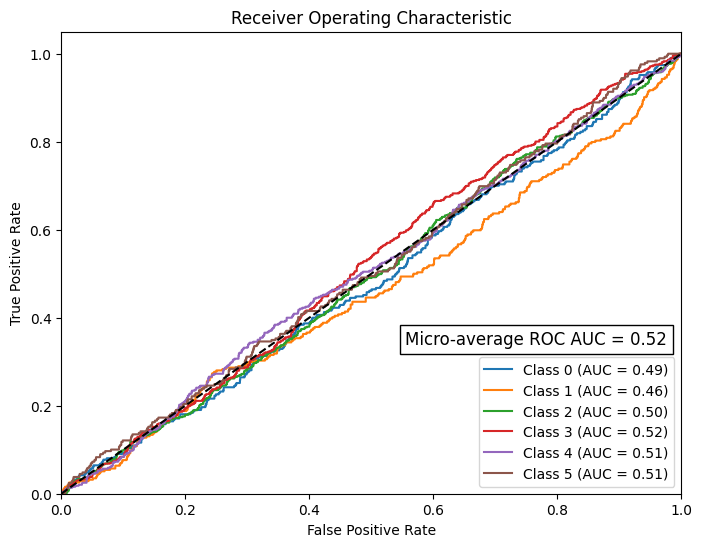

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))

# Calculate the ROC AUC score for each class
roc_auc_scores = roc_auc_score(y_true_binarized, y_pred_prob, average='micro')

# Plot the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_pred_prob[:, i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(test_generator.class_indices)):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot the random chance curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Add micro-average ROC AUC score to the plot
plt.text(0.555, 0.34, 'Micro-average ROC AUC = %0.2f' % roc_auc_scores, fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

# Generate predictions for the training data
train_pred = model.predict(train_generator)
train_pred = np.argmax(train_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the validation data
val_pred = model.predict(val_generator)
val_pred = np.argmax(val_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the testing data
test_pred = model.predict(test_generator)
test_pred = np.argmax(test_pred, axis=1)  # Convert predictions to class labels

# Calculate overall MAE and RMSE
train_mae = mean_absolute_error(train_generator.classes, train_pred)
train_rmse = np.sqrt(mean_squared_error(train_generator.classes, train_pred))

val_mae = mean_absolute_error(val_generator.classes, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_generator.classes, val_pred))

test_mae = mean_absolute_error(test_generator.classes, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_generator.classes, test_pred))

print("Overall MAE - Training: {:.4f}".format(train_mae))
print("Overall RMSE - Training: {:.4f}".format(train_rmse))
print("Overall MAE - Validation: {:.4f}".format(val_mae))
print("Overall RMSE - Validation: {:.4f}".format(val_rmse))
print("Overall MAE - Testing: {:.4f}".format(test_mae))
print("Overall RMSE - Testing: {:.4f}".format(test_rmse))

244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step

2025-06-15 13:17:53.328603: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2166', 4 bytes spill stores, 4 bytes spill loads

2025-06-15 13:17:53.412567: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2166', 100 bytes spill stores, 100 bytes spill loads

2025-06-15 13:17:53.446384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2166', 64 bytes spill stores, 64 bytes spill loads



245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Overall MAE - Training: 1.7122
Overall RMSE - Training: 2.1523
Overall MAE - Validation: 1.7111
Overall RMSE - Validation: 2.1394
Overall MAE - Testing: 1.7386
Overall RMSE - Testing: 2.1606


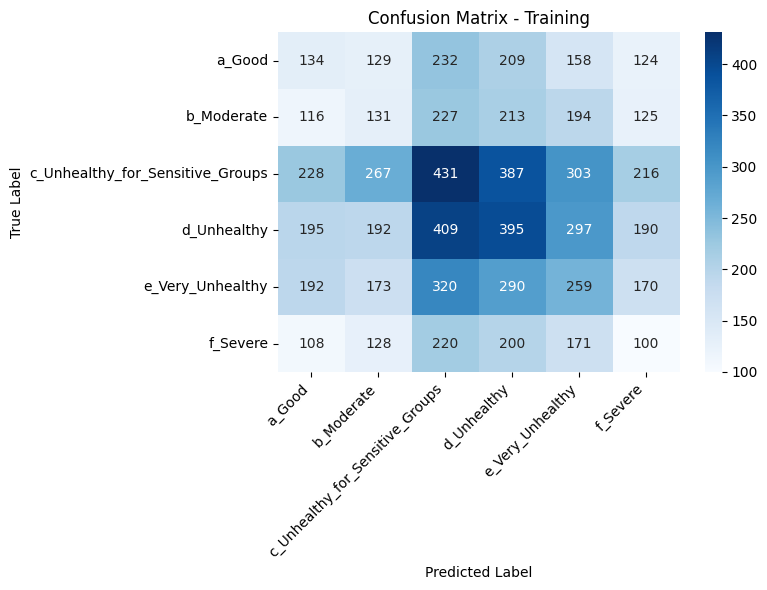

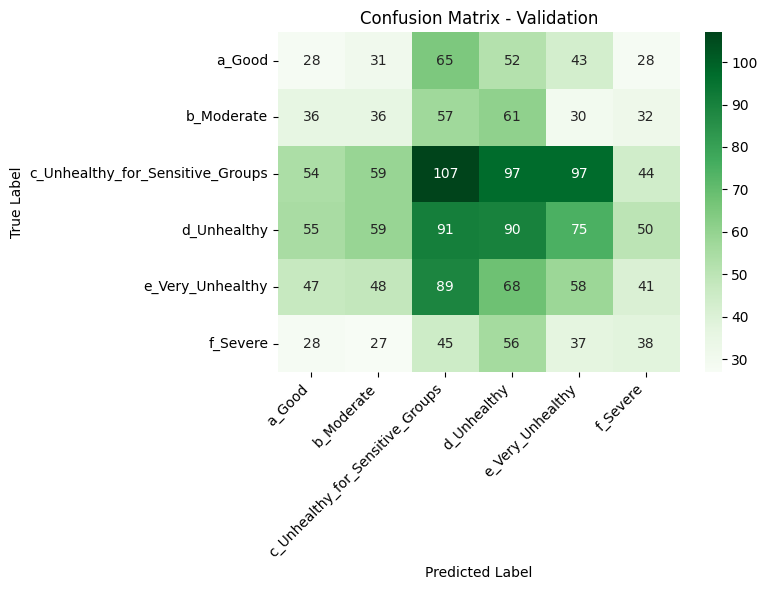

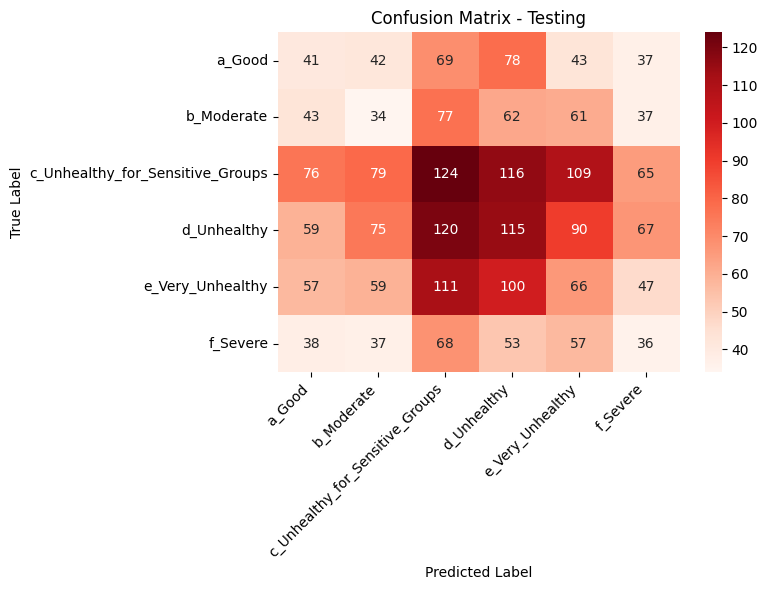

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
train_cm = confusion_matrix(train_generator.classes, train_pred)
val_cm = confusion_matrix(val_generator.classes, val_pred)
test_cm = confusion_matrix(test_generator.classes, test_pred)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Testing')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()
